In [1]:
using Revise
using RealNeuralNetworks.Neurons
using RealNeuralNetworks.Neurons.Segments 
using RealNeuralNetworks.NeuralNets
using JLD2
using PyPlot
using MultivariateStats
using ProgressMeter

DATASET_DATE = "20190415"

┌ Info: Recompiling stale cache file /usr/people/jingpeng/.julia/compiled/v0.7/RealNeuralNetworks/RIwuY.ji for RealNeuralNetworks [a02b0709-7910-5c23-8877-7dbb2b717a71]
└ @ Base loading.jl:1185
Expr(:const, Symbol("##get_bounding_box_memoized_cache") = Expr(:call, :IdDict))
  ** incremental compilation may be broken for this module **



In [2]:
neuronId2neuron = Dict{Int,Neuron}()

DIR = "../01_data/$(DATASET_DATE)/atlas_space/"
for fileName in readdir(joinpath(DIR,"bin"))
    if endswith(fileName, ".bin")
        neuronId = Meta.parse(split(fileName, ".")[1])
        fullName = joinpath(DIR, "bin", fileName)
        neuron = Neurons.load(fullName)
        neuronId2neuron[neuronId] = neuron
    end
end

# @save joinpath(DIR, "neuronId2neuron.jld2") neuronId2neuron
# @load joinpath(DIR, "neuronId2neuron.jld2") neuronId2neuron

In [3]:
# select orphan axons
@load "data/orphanAxonIdSet.jld" orphanAxonIdSet

1-element Array{Symbol,1}:
 :orphanAxonIdSet

In [4]:
pathLengthList = Vector{Float32}()
numSynapseList = Vector{Int}()
for neuronId in fullNeuronIdSet
    neuron = neuronId2neuron[neuronId]
    pathLength = Neurons.get_total_path_length(neuron)
    numSynapse = Neurons.get_num_post_synapses(neuron) + Neurons.get_num_pre_synapses(neuron)
    if numSynapse > 3000
        @show neuronId
        @show Neurons.get_num_post_synapses(neuron)
        @show Neurons.get_num_pre_synapses(neuron)
    end
    push!(pathLengthList, pathLength)
    push!(numSynapseList, numSynapse)
end
PyPlot.scatter(pathLengthList./1000, numSynapseList, alpha=0.5)
PyPlot.xlabel(L"path\ length\ (\mu m)")
PyPlot.ylabel("# of synapses")
PyPlot.xlim(0, )#2000)
PyPlot.ylim(0, )#1000)
# PyPlot.title("synapse number vs synapse number")

# fit a line 

UndefVarError: UndefVarError: fullNeuronIdSet not defined

# clustering of orphan axons
based on direction of farthest terminal point pairs

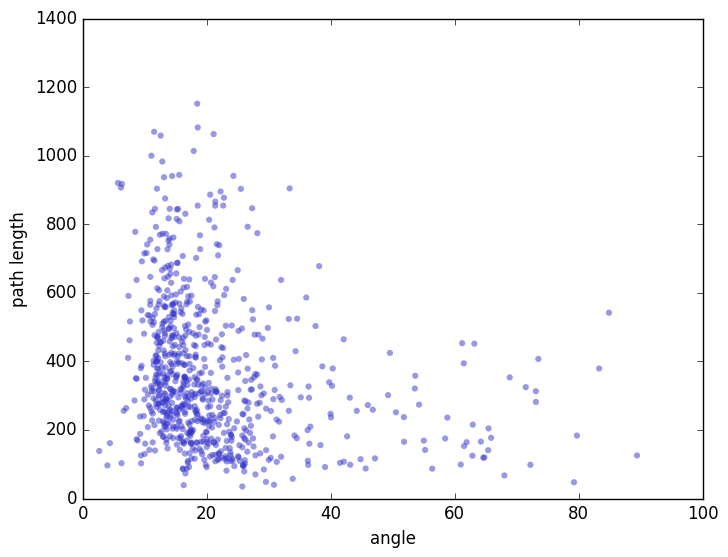

perpendicularNeuronIdSet = Set([76928, 77358, 78113, 78185, 79132, 77472, 78335, 78089, 79141, 79455, 78773, 77864, 78805, 79197, 77348, 78687, 77030, 78834, 77466, 77044, 78693, 77778, 78985, 78670, 78615, 79142, 76915, 76774, 78852, 78340, 77018, 78632, 79488, 76949, 78684, 78617, 78240, 77303, 78298, 78680, 79533, 78627, 79709, 78094, 77025, 77047, 76777, 79456, 79202, 79523, 77304, 79043, 78831, 77748])
parallelNeuronIdSet = Set([78802, 78628, 79475, 78953, 79823, 79878, 79828, 78110, 79163, 78654, 79735, 79815, 78797, 79477, 79804, 78900, 76783, 76675, 78096, 78826, 77452, 77757, 79855, 78857, 78761, 77755, 78634, 78415, 76929, 79507, 78328, 77471, 77366, 77746, 79939, 77385, 79155, 79484, 78056, 78666, 79930, 76962, 77742, 78154, 78131, 78259, 79482, 76666, 78054, 78655, 78134, 79680, 79175, 76957, 76684, 78173, 78969, 78807, 79738, 79182, 78644, 77377, 77767, 79467, 78856, 79165, 79172, 78146, 79965, 79767, 78948, 78800, 79157, 79768, 78926, 78864, 78799, 78339, 78169, 77262, 79

In [5]:
using LinearAlgebra

angleList = Vector{Float32}()
maxDistanceList = Vector{Float32}()
pathLengthList = Vector{Float32}()
synapticDistanceList = Vector{Float64}()

parallelNeuronIdSet = Set{Int}()
perpendicularNeuronIdSet = Set{Int}()

for neuronId in orphanAxonIdSet
    neuron = neuronId2neuron[ neuronId ]
    v, maxNodeDistance = Neurons.get_furthest_terminal_node_pair_direction(neuron)
    
#     # ignore the y axis (M-L) of vector
#     v[2] = zero(Float32)
#     @show v
    # compute angle with x axis (A-D)
    angle = abs( v[1] / norm(v) ) |> acosd
    
    pathLength = Neurons.get_total_path_length(neuron)
    synapseNum = Neurons.get_num_post_synapses(neuron) + Neurons.get_num_pre_synapses(neuron)
    
    if pathLength>400 && angle<30 && angle>10
        push!(parallelNeuronIdSet, neuronId)
    end
    if angle>40 && angle<90
        push!(perpendicularNeuronIdSet, neuronId)
    end
        
    
    push!(angleList, angle)
    push!(maxDistanceList, maxNodeDistance)
    push!(pathLengthList, pathLength)
    push!(synapticDistanceList, pathLength / synapseNum)
end

# PyPlot.scatter(angleList, synapticDistanceList)
PyPlot.scatter(angleList, pathLengthList./1000, c=(0.2, 0.2, 0.8, 0.5), edgecolor="None")
PyPlot.xlim(0,)
PyPlot.ylim(0,)
PyPlot.xlabel("angle")
PyPlot.ylabel("path length")
PyPlot.savefig("fig/orphan_axon_distribution.svg")

@show perpendicularNeuronIdSet;
@show parallelNeuronIdSet;

@save "data/parallelNeuronIdSet.jld" parallelNeuronIdSet
@save "data/perpendicularNeuronIdSet.jld" perpendicularNeuronIdSet

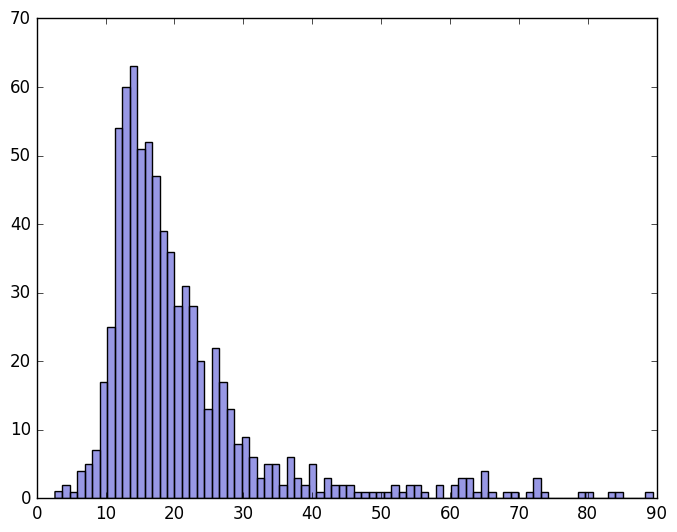

In [6]:
# there is a nan value in the angle list
PyPlot.plt[:hist](angleList[.!isnan.(angleList)], bins=80, color=(0.2, 0.2, 0.8, 0.5));

In [7]:
# bundle detection by examining 
using NearestNeighbors
using Statistics

M = length(parallelNeuronIdSet)
distanceMatrix = zeros(Float32, M,M)
parallelNeuronIdList = [parallelNeuronIdSet...,]

@showprogress 1 "compute axon distances ..." for (i, neuronId1) in enumerate(parallelNeuronIdList)
    neuron1 = neuronId2neuron[neuronId1]
    nodeList1 = Neurons.get_node_list(neuron1)
    coords1 = zeros(Float32, 3, length(nodeList1))
    for (m, node) in enumerate(nodeList1)
        coords1[:, m] = [node[1:3]...,]
    end
    kdtree1 = NearestNeighbors.KDTree(coords1; leafsize=10)
    for j in i+1:M
        neuronId2 = parallelNeuronIdList[j]
        neuron2 = neuronId2neuron[neuronId2]
        nodeList2 = Neurons.get_node_list(neuron2)[1:20:end]
        coords2 = zeros(Float32, 3, length(nodeList2))
        for (m, node) in enumerate(nodeList2)
            coords2[:, m] = [node[1:3]...,]
        end
        
        # compute nearest neighbor and distances
        idxs, dists = knn(kdtree1, coords2, 1)
        dists = map(d -> d[1], dists)
        distanceMatrix[i,j] = median(dists)
        # make the matrix symmetric
        distanceMatrix[j,i] = distanceMatrix[i,j]
#         break
    end
#     break
end

# PyPlot.matshow(distanceMatrix)

compute axon distances ...100%|█████████████████████████| Time: 0:04:09


In [15]:
using Clustering
# using StatPlots
using StatsBase

hc = hclust(distanceMatrix; linkage=:ward)
# StatPlots.plot(hc)

using Plots

function hclustplot(hc::Hclust, useheight::Bool)
    o = indexmap(hc.order)
    n = [x for x in 1:length(o)]

    pos = treepositions(hc, useheight)


    xs = []
    ys = []
    for i in 1: size(hc.merge, 1)
        x1 = pos[hc.merge[i,1]][1]
        x2 = pos[hc.merge[i,2]][1]
        append!(xs, [x1,x1,x2,x2])

        y1 = pos[hc.merge[i,1]][2]
        y2 = pos[hc.merge[i,2]][2]
        useheight ? h = hc.height[i] : h = 1
        newy = maximum([y1,y2]) + h
        append!(ys, [y1,newy,newy,y2])
    end
    return (reshape(xs, 4, size(hc.merge, 1)), reshape(ys, 4, size(hc.merge, 1)))
end

function treepositions(hc::Hclust, useheight::Bool)
    order = indexmap(hc.order)
    positions = Dict{}()
    for (k,v) in order
        positions[-k] = (v, 0)
    end
    for i in 1:size(hc.merge,1)
        xpos = mean([positions[hc.merge[i,1]][1], positions[hc.merge[i,2]][1]])
        if hc.merge[i,1] < 0 && hc.merge[i,2] < 0
            useheight ? ypos = hc.height[i] : ypos = 1
        else
            useheight ? h = hc.height[i] : h = 1
            ypos = maximum([positions[hc.merge[i,1]][2], positions[hc.merge[i,2]][2]]) + h
        end

        positions[i] = (xpos, ypos)
    end
    return positions
end

Plots.gr()
Plots.plot(hclustplot(hc, true), seriestype=:path, color=:black,
    grid=false, legend=false) #Vector(ndf[:cellId][clust.order]))
Plots.savefig("fig/hierachical_clustering_of_orphan_parallel_axons.png")

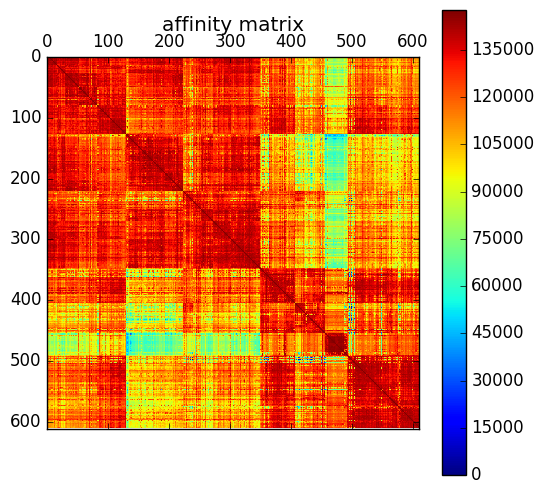

PyObject <matplotlib.colorbar.Colorbar object at 0x7feff8f1de10>

In [16]:
# rearrange distance matrix according to order
reorderedDistanceMatrix = zero(distanceMatrix)
for (i,o1) in enumerate(hc.order)
    for (j, o2) in enumerate(hc.order)
        reorderedDistanceMatrix[i,j] = distanceMatrix[o1,o2]
    end 
end 
PyPlot.matshow(maximum(reorderedDistanceMatrix) .- reorderedDistanceMatrix)
PyPlot.title("affinity matrix")
PyPlot.colorbar()



# cutree(hc; k = )

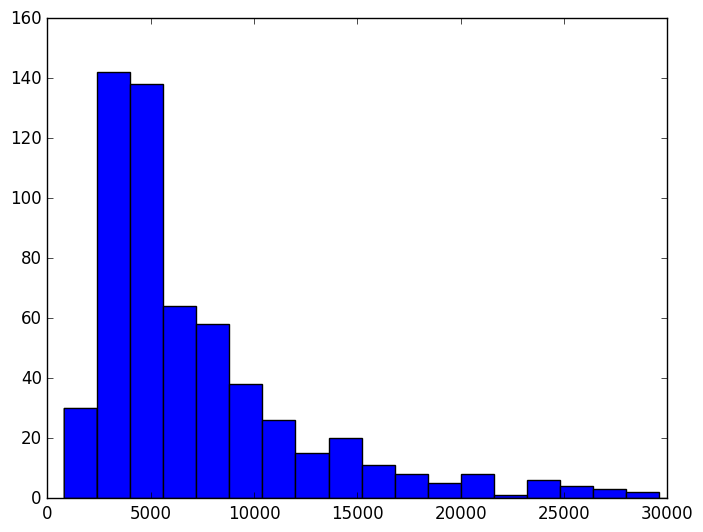

(0, 30000)

In [25]:
PyPlot.plt[:hist](hc.height, bins=400);
PyPlot.xlim(0,30000)

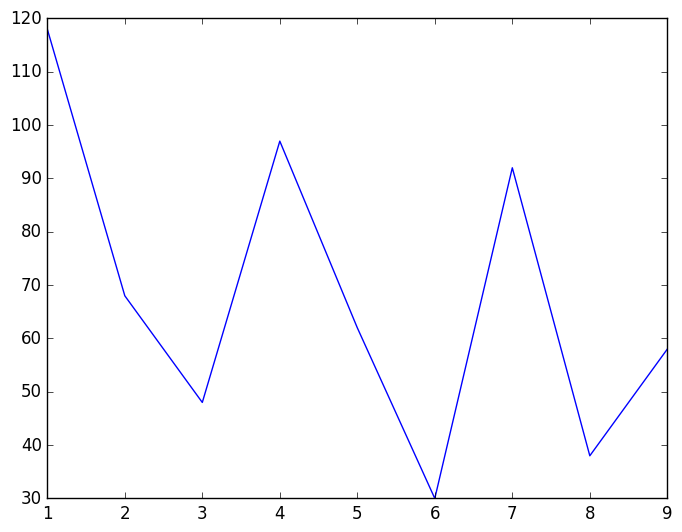

9 labels within 611 parallel axons
label of 1 contains [78802, 78953, 78654, 76783, 76675, 77757, 78857, 78415, 77366, 79939, 77385, 78056, 78666, 76666, 78054, 78655, 76684, 77767, 78856, 78800, 78799, 78851, 77394, 77852, 77811, 77391, 77759, 77392, 77862, 77326, 77660, 78418, 76681, 78347, 79807, 78647, 78594, 79810, 76628, 78695, 76787, 78597, 77858, 77399, 79936, 78694, 77386, 79498, 77371, 77817, 78982, 77863, 79928, 77754, 78762, 77873, 77780, 78912, 77768, 78677, 77770, 76778, 76844, 77773, 76846, 79020, 77857, 78652, 78651, 77869, 76659, 79262, 79808, 78980, 77819, 77782, 79515, 76694, 77753, 79927, 77820, 79937, 78850, 76843, 77772, 76786, 78604, 78905, 76632, 78596, 77376, 77756, 78973, 77766, 76779, 78918, 77809, 77818, 77828, 78619, 77771, 79201, 77758, 76664, 79877, 78848, 78916, 78602, 77339, 78853, 77765, 77802, 77775, 76693, 79481, 78635, 78981, 76784]

label of 2 contains [78628, 79735, 78797, 79155, 79965, 79767, 79768, 79200, 79233, 79156, 79195, 79881, 79869, 79129

In [27]:
reorderedAxonIdList = parallelNeuronIdList[hc.order]


# labelList = cutree(hc; h=1e4)
labelList = cutree(hc; k=9)
labelId2neuronIdList = Dict{Int, Vector{Int}}()
for (i, labelId) in enumerate(labelList)
    labelId2neuronIdList[labelId] = Vector{Int}()
end
for (i, labelId) in enumerate(labelList)
    neuronId = parallelNeuronIdList[ i ]
    push!(labelId2neuronIdList[ labelId ], neuronId)
end
    
println(maximum(labelList), " labels within ", length(reorderedAxonIdList), " parallel axons")

labelIdNumList = zeros(Int, maximum(labelList))
for l in labelList
    labelIdNumList[l] += 1
end

for (labelId, labelIdNum) in labelIdNumList |> enumerate
    if labelIdNum > 7
        println("label of ", labelId, " contains ", labelId2neuronIdList[ labelId ], "\n")
    end
end

PyPlot.plot(1:length(labelIdNumList), labelIdNumList);

# Clustering based on [NBlast](http://flybrain.mrc-lmb.cam.ac.uk/si/nblast/www/nblast_desktop/)


In [31]:
# order = [ 86 238  38 110   6 188 271 318 214 226  66 117   9  37  54 323  48  95 111 333 246 309 124 277   8 201  78 159  69 133 228  99 210  59 295 199 321  77 311  24 103 152 275 112 166 177 129 168  67 322 260 307  22  57 109 121 202  52 181  44 108 107 151 156 218  65  91  73 233 105 142 219 312  39 265  94  98 172 261 200 204  50  71   4  83 308 137 184 189 224 237  14 145  92 183 139 215  21 327 255 193 282 302   1 258   3 247  45 267 122 294 313  55 190 120 217 256 335 175 192 325 281 324  97 127 187 147 225  49  63  18 242 114 262 185 209 241 293 273  17  23 310 334 331 101 286  33 140 197 315 254 278 134 191 115 223 243 279  82 118 51  60 301  62 167 154 266 161 195 126 244  70  79 291 102 106 153 180 138 274  31 173 113 249 149 165  32 212  41 299  35 231 36  15 155  88 235 257 227 239 270  89 245  12 284 179 269 206   2 131 160 248  56 163 296 119 328 169  64 234  40 290  74  76 81 198  53  75  96 100 158  28 143  26  68  34 178 176 205  46 319  20 317  47 268 123 259  58 222 280  13 264  19  90 208 232 314 300  27 263 116 146 186 288  29 304  42 298 332  61 236 276  80 170 230 289 211   7  93 157 303 104 213 330 150 305 207 240  128 135 174  84 171 144 292 221 320 203 297 194 283 136 285 182 272 252 326 164   5  87  25 125 162 196 251 316  16 329  10  43  85  72 253 216  11 220 132 306 250 148 287 130 229  30 141]

1×335 Array{Int64,2}:
 86  238  38  110  6  188  271  318  214  …  250  148  287  130  229  30  141

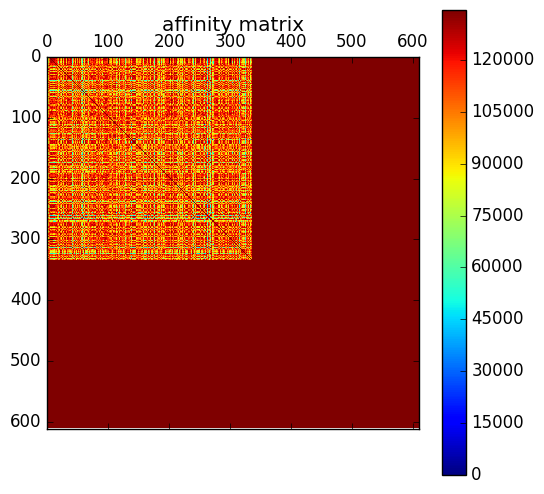

PyObject <matplotlib.colorbar.Colorbar object at 0x7fef9e65e400>

In [32]:
# rearrange distance matrix according to order
reorderedDistanceMatrix = zero(distanceMatrix)
for (i,o1) in enumerate(order)
    for (j, o2) in enumerate(order)
        reorderedDistanceMatrix[i,j] = distanceMatrix[o1,o2]
    end 
end 
PyPlot.matshow(maximum(reorderedDistanceMatrix) .- reorderedDistanceMatrix)
PyPlot.title("affinity matrix")
PyPlot.colorbar()


# Classification based on morphological features
use principle component analysis

In [19]:
featureList = Set(Neurons.get_path_length_normalized_features(neuronId2neuron[id]) for id = orphanAxonIdSet)
featureList = [featureList...];


In [20]:
using StatsBase

# featureDict = Dict{Symbol, Vector{Float64}}()
X = zeros(length(featureList[1]|>keys), length(featureList))

for (i, key) in keys(featureList[1]) |> enumerate
    featureVector = map(x->x[key], featureList)
    featureVector = StatsBase.zscore(featureVector)
    X[i, :] = featureVector
end

X

8×742 Array{Float64,2}:
  0.337579  -0.311667    -0.374112   …   0.519475   0.289804  -0.243599 
  0.241311   0.294746    -0.0150471     -0.508426   0.421343  -0.446797 
 -0.782228  -1.03247     -0.675177      -0.175905  -1.19031    0.330573 
  0.164636  -0.0306023   -0.541134       0.169008  -1.57701    0.75585  
  0.152842  -0.683688    -0.917241       0.808651   1.01166    0.196346 
 -0.113214   0.965186     0.140146   …  -0.57008   -0.27503   -0.0653186
 -0.265681  -0.0273351   -0.160567      -0.921966  -0.88728    0.442938 
 -0.277218  -0.00364843  -0.215785      -0.90487   -0.853826   0.471407 

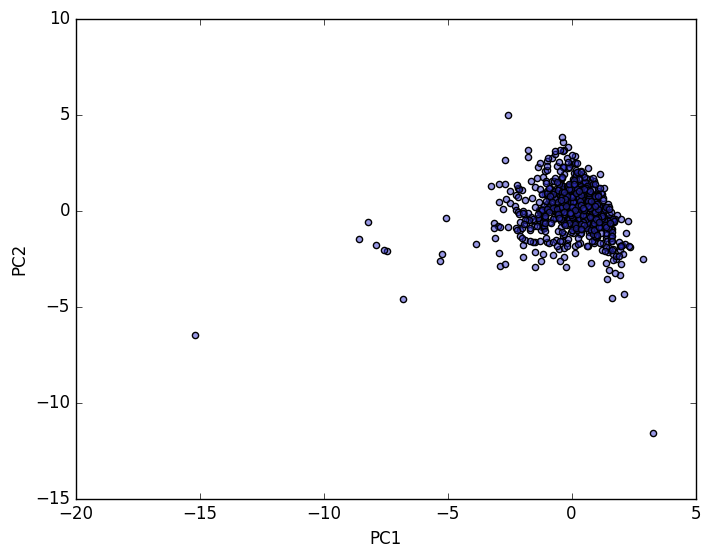

PyObject <matplotlib.text.Text object at 0x7feff8db3a58>

In [21]:

M = fit(PCA, X; maxoutdim=2, pratio=1.0)
y = transform(M, X)
PyPlot.scatter(y[1,:], y[2,:], c=(0.2, 0.2, 0.8, 0.5))
PyPlot.xlabel("PC1")
PyPlot.ylabel("PC2")